# Example: Predictions for HRES T0

In this example, we will download HRES T0 data for 11 May 2022 from [WeatherBench2](https://weatherbench2.readthedocs.io/) at 0.25 degrees resolution and run Aurora on this data. We will use the version of Aurora that was fine-tuned on IFS HRES T0 in this example.

Running this notebook requires additional Python packages. You can install these as follows:

```
pip install gcsfs cdsapi xarray zarr netcdf4 matplotlib
```

## Downloading the Data

To begin with, we download the data from [WeatherBench2](https://weatherbench2.readthedocs.io/).

In [7]:
from pathlib import Path

import fsspec
import xarray as xr

# Data will be downloaded here.
download_path = Path("~/downloads")

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# We will download from Google Cloud.
url = "gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr"
ds = xr.open_zarr(fsspec.get_mapper(url), chunks=None)

# Day to download. This will download all times for that day.
day = "2022-05-11"

# Download the surface-level variables. We write the downloaded data to another file to cache.
if not (download_path / f"{day}-surface-level.nc").exists():
    surface_vars = [
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "2m_temperature",
        "mean_sea_level_pressure",
    ]
    ds_surf = ds[surface_vars].sel(time=day).compute()
    ds_surf.to_netcdf(str(download_path / f"{day}-surface-level.nc"))
print("Surface-level variables downloaded!")

# Download the atmospheric variables. We write the downloaded data to another file to cache.
if not (download_path / f"{day}-atmospheric.nc").exists():
    atmos_vars = [
        "temperature",
        "u_component_of_wind",
        "v_component_of_wind",
        "specific_humidity",
        "geopotential",
    ]
    ds_atmos = ds[atmos_vars].sel(time=day).compute()
    ds_atmos.to_netcdf(str(download_path / f"{day}-atmospheric.nc"))
print("Atmos-level variables downloaded!")

Surface-level variables downloaded!
Atmos-level variables downloaded!


## Downloading Static Variables from ERA5 Data

The static variables are not available in WeatherBench2, so we need to download them from ERA5, just like we did [in the example for ERA5](example_era5.ipynb).
To do so, register an account with the [Climate Data Store](https://cds-beta.climate.copernicus.eu/) and create `$HOME/.cdsapirc` with the following content:

```
url: https://cds-beta.climate.copernicus.eu/api
key: <API key>
```

You can find your API key on your account page.

In order to be able to download ERA5 data, you need to accept the terms of use in the [dataset page](https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download).

In [2]:
from pathlib import Path

import cdsapi

# Data will be downloaded here.
download_path = Path("~/downloads")

c = cdsapi.Client()

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# Download the static variables.
if not (download_path / "static.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "geopotential",
                "land_sea_mask",
                "soil_type",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": "00:00",
            "format": "netcdf",
        },
        str(download_path / "static.nc"),
    )
print("Static variables downloaded!")

Static variables downloaded!


## Preparing a Batch

We convert the downloaded data to an `aurora.Batch`, which is what the model requires.

In [18]:
import numpy as np
import torch
import xarray as xr

from aurora import Batch, Metadata

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(download_path / f"{day}-surface-level.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(download_path / f"{day}-atmospheric.nc", engine="netcdf4")

i = 1  # Select this time index in the downloaded data.


def _prepare(x: np.ndarray) -> torch.Tensor:
    """Prepare a variable.

    This does the following things:
    * Select time indices `i` and `i - 1`.
    * Insert an empty batch dimension with `[None]`.
    * Flip along the latitude axis to ensure that the latitudes are decreasing.
    * Copy the data, because the data must be contiguous when converting to PyTorch.
    * Convert to PyTorch.
    """
    return torch.from_numpy(x[[i - 1, i]][None][..., ::-1, :].copy())


batch = Batch(
    surf_vars={
        "2t": _prepare(surf_vars_ds["2m_temperature"].values),
        "10u": _prepare(surf_vars_ds["10m_u_component_of_wind"].values),
        "10v": _prepare(surf_vars_ds["10m_v_component_of_wind"].values),
        "msl": _prepare(surf_vars_ds["mean_sea_level_pressure"].values),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time. They
        # don't need to be flipped along the latitude dimension, because they are from
        # ERA5.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": _prepare(atmos_vars_ds["temperature"].values),
        "u": _prepare(atmos_vars_ds["u_component_of_wind"].values),
        "v": _prepare(atmos_vars_ds["v_component_of_wind"].values),
        "q": _prepare(atmos_vars_ds["specific_humidity"].values),
        "z": _prepare(atmos_vars_ds["geopotential"].values),
    },
    metadata=Metadata(
        # Flip the latitudes! We need to copy because converting to PyTorch, because the
        # data must be contiguous.
        lat=torch.from_numpy(surf_vars_ds.latitude.values[::-1].copy()),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

## Loading and Running the Model

Finally, we are ready to load and run the model and visualise the predictions. We perform a roll-out for two steps, which produces predictions for hours 12:00 and 18:00.

In [19]:
from aurora import Aurora, rollout

model = Aurora()
model.load_checkpoint("microsoft/aurora", "aurora-0.25-finetuned.ckpt")

model.eval()
model = model.to("cuda")

with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model, batch, steps=2)]

model = model.to("cpu")

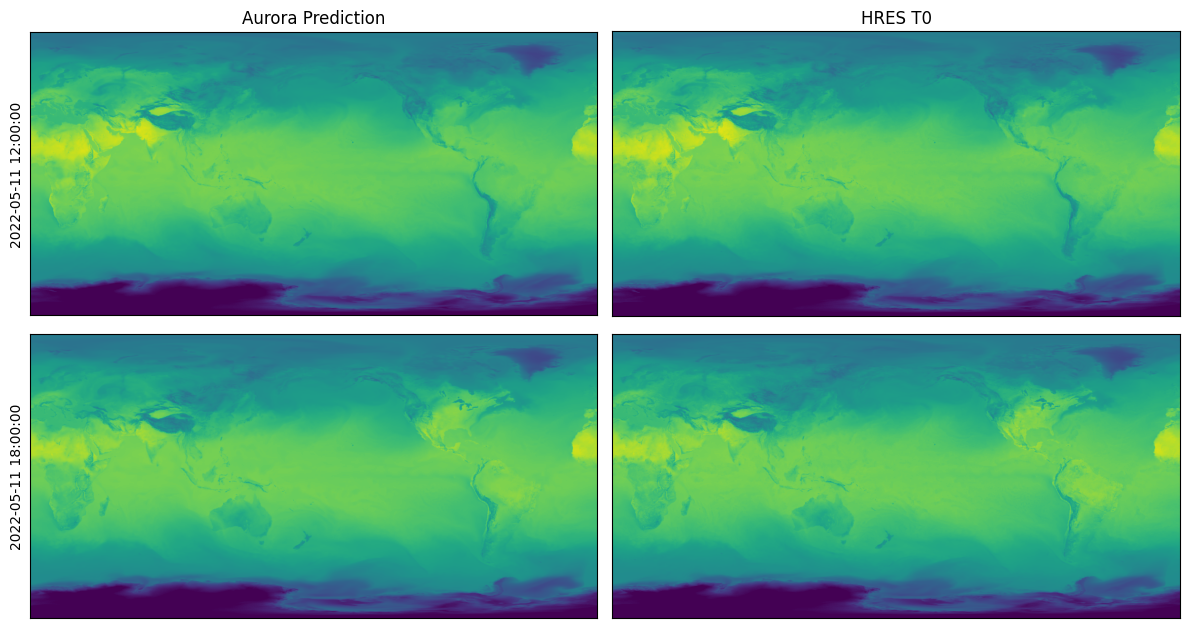

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 6.5))

for i in range(ax.shape[0]):
    pred = preds[i]

    ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50)
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Aurora Prediction")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    ref = surf_vars_ds["2m_temperature"][2 + i].values[::-1, :]
    ax[i, 1].imshow(ref - 273.15, vmin=-50, vmax=50)
    if i == 0:
        ax[i, 1].set_title("HRES T0")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])

plt.tight_layout()